# An Analysis of Factors Affecting the Yield of Crops in the USA and Mexico under No Till and Conventional Tillage Techniques

## A capstone project for Data Science and Analytics Course 503: Design of Experiments

**SUNY Polytechnic Institute**

By: Henry Zelenak

Advisor: Dr. William Thistleton

May 8, 2025

## 00 | Table of Contents

- [00 | Table of Contents](#00)
- [01 | Introduction](#01)
- [02 | Research Question](#02)
- [03 | Data Preprocessing and Visual Exploration](#03)
- [04 | Statistical Analysis](#04)
- [05 | Discussion](#05)
- [06 | Conclusion](#06)
- [07 | References](#references)

## 01 | Introduction
<a id="01"></a>

No-tillage (NT) agriculture, a cornerstone of conservation agriculture, offers potential benefits for soil health, carbon sequestration (Lal, 2004), and reduced erosion compared to conventional tillage (CT). However, the impact of NT on crop yields relative to CT is highly variable and context-dependent (Pittelkow et al., 2015; Su et al., 2021). Understanding the factors that drive this variability is crucial for guiding the adoption of NT practices effectively. Prior research highlights the influence of climate, soil properties, management practices (like rotation and irrigation), and the duration of NT adoption on its relative success (Pittelkow et al., 2015).
Leveraging the extensive global dataset compiled by Su et al. (2021), my aim in this analysis was to identify specific environmental and management factors that significantly influence the relative yield performance of NT compared to CT. I focused my investigation on maize, winter wheat, and soybean production within the southern North American regions (U.S. and Mexico). I employed statistical modeling techniques, specifically Robust Linear Models (RLM), to analyze the relative_yield_change variable, accounting for data transformations necessary to meet modeling assumptions and exploring potential interactions between key predictors.

## 02 | Research Question
<a id="02"></a>

Based on the analysis focusing on the direction and magnitude of the yield difference, my primary research question was:

*What environmental factors (soil texture, precipitation, average temperature) and management practices (irrigation, complex crop rotation, years under no-tillage) significantly influence the Relative Yield Change (defined as $RYC = \frac{Yield_{NT} - Yield_{CT}}{Yield_{CT}}$ and modelled as the log(x + 1) transformation of the relative yield change) between no-tillage and conventional tillage systems for maize, winter wheat, and soybean production in the U.S. and Mexico?*

This question can be defined as the following (oversimplified) hypothesis:

$H_0$: There is no significant difference in the RYC between no-tillage and conventional tillage systems for maize, winter wheat, and soybean production in the U.S. and Mexico based on environmental factors, management practices, and their interactions.

I chose a level of significance of $\alpha = 0.05$ for this analysis, which is a common threshold in agricultural research. This level balances the risk of Type I and Type II errors, ensuring that we do not overlook significant effects while maintaining a reasonable level of confidence in our findings.

## 03 | Data Preprocessing and Visual Exploration

<a id="03"></a>

### 03.1 | Import Libraries and load data

In [142]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
from plotly.subplots import make_subplots
import scipy.stats as stats
from patsy import dmatrix, dmatrices

In [143]:
df = pd.read_csv('Database.csv')

### 03.2 | Basic Data Exploration

In [144]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4403 entries, 0 to 4402
Data columns (total 53 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Author                                                                 4403 non-null   object 
 1   Journal                                                                4403 non-null   object 
 2   Year                                                                   4403 non-null   object 
 3   Site country                                                           4403 non-null   object 
 4   Location                                                               4403 non-null   object 
 5   Latitude                                                               4403 non-null   float64
 6   Longitude                                                              4403 non-null   f

In [145]:
df.describe()

,Latitude,Longitude,Initial year of NT practice ( or first year of experiment if missing),Sowing year,Harvest year,Years since NT started (yrs),Yield of CT,Yield of NT,Relative yield change,Sowing month,Harvesting month,P,E,PB,Tave,Tmax,Tmin
count,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000,4403.000000
mean,32.274147,-26.034072,1994.000681,2000.802862,2001.077220,7.801953,5255.197602,5056.168160,0.076113,6.695889,8.315240,520.743084,516.759420,3.983668,18.705704,29.565792,5.642903
std,20.578129,80.691005,11.300901,9.545188,9.659629,7.714483,3913.820606,3703.043686,1.920909,2.777277,2.313289,290.137055,115.140738,270.516387,5.682820,4.591855,7.646406
min,-42.630000,-147.870000,1962.000000,1980.000000,1980.000000,0.000000,10.000000,66.000000,-0.959400,1.000000,1.000000,-45.300000,229.020000,-741.692000,-1.680000,14.121650,-31.425030
25%,30.900000,-93.750000,1986.000000,1994.000000,1994.000000,2.000000,2459.500000,2400.000000,-0.121500,5.000000,6.000000,330.600000,440.173000,-176.709000,15.087500,26.678800,1.959840
50%,37.990000,-75.720000,1993.000000,2001.000000,2002.000000,5.000000,4150.000000,4015.000000,-0.025000,5.000000,9.000000,475.099997,512.061000,-33.867000,18.614286,29.545822,5.119180
75%,43.870000,37.170000,2003.000000,2009.000000,2009.000000,11.000000,7314.500000,7017.000000,0.077100,10.000000,10.000000,650.200000,579.474000,112.683000,22.125000,32.457737,9.235000
max,64.820000,172.450000,2016.000000,2017.000000,2017.000000,52.000000,39730.000000,39832.000000,106.000000,12.000000,12.000000,2218.300000,1020.887000,1426.630000,31.780000,41.915010,27.144980


Based on the numerous variables present in the database, I want to aim for a large number of samples in my analysis to allow for the inclusion of as many variables as possible. Noting several qualitative variables, such as Site country, Crop, Crop rotation with at least 3 crops involved in CT, Crop rotation with at least 3 crops involved in NT, Cover crop before sowing, Soil cover in CT, Soil cover in NT, Weed and pest control CT, Weed and pest control NT, Fertilization CT, Fertilization NT, Irrigation CT, Irrigation NT, Water applied in CT, Water applied in NT, Outlier of CT, Outlier of NT, and ST, I am interested in their distribution or balance primarily, as that implicates the potential for bias in the analysis. I will also check the distribution of the quantitative variables or interest, such as , Yield increase with NT, P, E, PB, Tave, Tmax, Tmin.

The response is RYC, the relative directional difference between the yield of NT and CT ( $\frac{Yield_{NT} - Yield_{CT}}{Yield_{CT}}$ ).

In [146]:
# Show the distribution of non-null samples in each Site country
df['Site country'].value_counts()

,count
Site country,
USA,1692
Canada,565
India,404
China,395
Spain,154
Brazil,100
Mexico,84
South Africa,74
Italy,67


I wanted to see the number of samples in each country so that I could determine a region (the U.S. and Mexico, Europe, Asia, etc.) that had a relatively high number of samples.

In [147]:
df['Crop'].value_counts()

,count
Crop,
maize,1690
wheat.winter,1041
soybean,583
barley.spring,232
wheat.spring,209
rice,195
sorghum,160
barley.winter,138
cotton,94


I was also interested in the number of samples in each crop type, as this could allow me to make the analysis more specific to a certain crop type.

In [148]:
pd.set_option('display.max_columns', None)
df.head()

,Author,Journal,Year,Site country,Location,Latitude,Longitude,Soil information recorded in the paper,pH (surface layer),Replications in experiment,Crop,Initial year of NT practice ( or first year of experiment if missing),Sowing year,Harvest year,Years since NT started (yrs),Crop growing season recorded in the paper,Crop rotation with at least 3 crops involved in CT,Crop rotation with at least 3 crops involved in NT,Crop sequence (details),Cover crop before sowing,Soil cover in CT,Soil cover in NT,Residue management of previous crop in CT (details),Residue management of previous crop in NT (details),Weed and pest control CT,Weed and pest control NT,Weed and pest control CT (details),Weed and pest control NT (details),Fertilization CT,Fertilization NT,N input,N input rates with the unit kg N ha-1 (details),Field fertilization (details),Irrigation CT,Irrigation NT,Water applied in CT,Water applied in NT,Other information,Yield of CT,Yield of NT,Relative yield change,Yield increase with NT,Outlier of CT,Outlier of NT,Sowing month,Harvesting month,P,E,PB,Tave,Tmax,Tmin,ST
0,Aase et al.,Soil & Tillage Research,1997,USA,"Montana, Froid",48.28,-105.10,sandy loam,,3,wheat.winter,1990,1992,1992,3,NaN,No,No,continuous,NaN,NaN,NaN,NaN,NaN,Yes,Yes,Herbicide,Herbicide,Yes,Yes,Yes,NaN,"224 kg ha-1 (NH4)2HPO3 in 1991, 1992 & 34 kg h...",NaN,NaN,NaN,NaN,Plots were 12x30 m oriented the long way east ...,2567.0,2694.0,0.0495,Yes,NaN,NaN,9,8,395.800000,534.828000,-139.028,5.03333,24.798600,-20.095680,Loam
1,Aase et al.,Soil & Tillage Research,1997,USA,"Montana, Froid",48.28,-105.10,sandy loam,,3,wheat.winter,1990,1993,1993,4,NaN,No,No,continuous,NaN,NaN,NaN,NaN,NaN,Yes,Yes,Herbicide,Herbicide,Yes,Yes,Yes,NaN,"224 kg ha-1 (NH4)2HPO3 in 1991, 1992 & 34 kg h...",NaN,NaN,NaN,NaN,Plots were 12x30 m oriented the long way east ...,2405.0,2439.0,0.0141,Yes,NaN,NaN,9,8,260.300000,590.273000,-329.973,5.79167,29.191860,-21.602860,Loam
2,Aase et al.,Soil & Tillage Research,1997,USA,"Montana, Froid",48.28,-105.10,sandy loam,,3,wheat.winter,1990,1994,1994,5,NaN,No,No,continuous,NaN,NaN,NaN,NaN,NaN,Yes,Yes,Herbicide,Herbicide,Yes,Yes,Yes,NaN,"224 kg ha-1 (NH4)2HPO3 in 1991, 1992 & 34 kg h...",NaN,NaN,NaN,NaN,Plots were 12x30 m oriented the long way east ...,2439.0,2788.0,0.1431,Yes,NaN,NaN,9,8,397.300000,555.260000,-157.960,6.86667,29.487280,-16.195720,Loam
3,Acharya,Soil & Tillage Research,2019,USA,"Bossier City, Louisiana",32.42,-93.64,sandy loam,6.6,3,soybean,2014,2016,2016,3,4 to 10,Yes,Yes,Progeny wheat - BWI hairy vetch as cover crops...,Yes,No,Yes,incorporated,cover crop residue retained,Yes,Yes,Paraquat used to terminate cover crops,Paraquat used to terminate cover crops,Yes,Yes,Yes,63.4 for CT 56.5 for NT,cover crops' residue,NaN,NaN,NaN,NaN,The soil of the experimental site is classifie...,3005.0,2943.0,-0.0206,No,NaN,NaN,6,10,511.900005,546.686888,-34.787,26.16000,35.331630,14.984884,Loam
4,Acharya,Soil & Tillage Research,2019,USA,"Bossier City, Louisiana",32.42,-93.64,sandy loam,6.6,3,soybean,2014,2017,2017,4,5 to 9,Yes,Yes,Progeny wheat - BWI hairy vetch as cover crops...,Yes,No,Yes,incorporated,cover crop residue retained,Yes,Yes,Paraquat used to terminate cover crops,Paraquat used to terminate cover crops,Yes,Yes,Yes,240 for CT 167 for NT,cover crops' residue,NaN,NaN,NaN,NaN,The soil of the experimental site is classifie...,3062.0,2670.0,-0.1280,No,NaN,NaN,6,10,475.099997,511.402611,-36.303,24.96000,34.272689,13.003511,Loam


Before I proceed with cleaning, I want to note that Su et al. (2021) mention in the Technical Validation section of their paper that outliers in 'Yield of NT' and 'Yield of CT' were flagged during their validation. These columns will be 'Yes' if the yield was flagged as an outlier and NaN if it was not. I will remove the flagged outliers and check the dataset size to see how many samples I have left.

In [149]:
print(f"Size of the dataset before dropping outliers in Yield of NT and Yield of CT: {df.shape}")
# Remove flagged outliers (where 'Outlier of NT', 'Outlier of CT' are Yes)
df = df[(df['Outlier of NT'] != 'Yes') & (df['Outlier of CT'] != 'Yes')]
print(f"Size of the dataset after dropping outliers in Yield of NT and Yield of CT: {df.shape}")

Size of the dataset before dropping outliers in Yield of NT and Yield of CT: (4403, 53)
Size of the dataset after dropping outliers in Yield of NT and Yield of CT: (4382, 53)


21 outlier samples were removed.

In [150]:
print(f"Size of the dataset before dropping rows with missing values: {df.shape}")
df.drop_duplicates(inplace=True)
print(f"Size of the dataset after dropping duplicates: {df.shape}")

Size of the dataset before dropping rows with missing values: (4382, 53)
Size of the dataset after dropping duplicates: (4378, 53)


Four duplicate samples were removed.

### 03.3 | Data Subsetting and Cleaning

In [151]:
#from geopy.geocoders import Nominatim
#import geopandas as gpd
#from shapely.geometry import Point

df.drop_duplicates(inplace=True)

df_NA_M_WW = df[df['Site country'].isin(['USA', 'Canada', 'Mexico'])]

# Filter the DataFrame to include only rows where 'Crop' is 'maize' or wheat.winter or 'soybean' (the three crops of interest)
df_NA_M_WW = df_NA_M_WW[df_NA_M_WW['Crop'].isin(['maize', 'wheat.winter', 'soybean'])]

# Remove leading and trailing spaces from column names
df_NA_M_WW.columns = df_NA_M_WW.columns.str.strip()

# Quantitative columns:  Years since NT started (yrs), P, Tave
# Qualitative columns:  Irrigation CT, Irrigation NT, Crop rotation with at least 3 crops involved in CT, Crop rotation with at least 3 crops involved in NT, ST, Crop, Site country

# Select the quantitative and qualitative columns
columns_to_select = [
    'Author',
    'Year',
    'Latitude',
    'Longitude',
    'Years since NT started (yrs)',
    'P',
    'Tave',
    'Irrigation CT',
    'Irrigation NT',
    'Crop rotation with at least 3 crops involved in CT',
    'Crop rotation with at least 3 crops involved in NT',
    'ST',
    'Crop',
    'Site country',
    'Relative yield change'
]

# Create a new DataFrame with the selected columns
df_NA_M_WW_clean = df_NA_M_WW.copy()[columns_to_select]

# Rename 'Years since NT started (yrs)' to 'years_since_nt_start'
df_NA_M_WW_clean.rename(columns={'Years since NT started (yrs)': 'years_since_nt_start'}, inplace=True)

# Rename the columns for clarity (lowercase, no spaces)
df_NA_M_WW_clean.columns = [col.lower().replace(' ', '_') for col in df_NA_M_WW_clean.columns]

# Drop rows with missing values
df_NA_M_WW_clean.dropna(inplace=True)

# Drop rows where any value is ' '
df_NA_M_WW_clean = df_NA_M_WW_clean[~df_NA_M_WW_clean.isin([' ']).any(axis=1)]

# Drop rows where 'years_since_nt_started_yrs' or 'P' or 'Tave' is less than 0
df_NA_M_WW_clean = df_NA_M_WW_clean[(df_NA_M_WW_clean['years_since_nt_start'] >= 0) & (df_NA_M_WW_clean['p'] >= 0) & (df_NA_M_WW_clean['tave'] >= 0)]

# Drop rows where ST is 'Clay loam'
df_NA_M_WW_clean = df_NA_M_WW_clean[df_NA_M_WW_clean['st'] != 'Clay loam']

# Drop duplicate rows
df_NA_M_WW_clean.drop_duplicates(inplace=True)

# Reset the index after dropping rows
df_NA_M_WW_clean.reset_index(drop=True, inplace=True)

print("DataFrame Info for Maize, Winter Wheat, and Soybean in the U.S. and Mexico:")
df_NA_M_WW_clean.info()
print("\n" + "="*50 + "\n")

for col in df_NA_M_WW_clean.columns:
    if df_NA_M_WW_clean[col].dtype == 'object':
        print(f"{col}: {df_NA_M_WW_clean[col].unique()}")
        print("=" * 30)

    else:
        print(f"{col}: {df_NA_M_WW_clean[col].describe()}")
        print("=" * 30)

# Show the skewness of the quantitative columns
print("\nSkewness of Quantitative Columns:")
for col in df_NA_M_WW_clean.select_dtypes(include=['float64', 'int64']).columns:
    skewness = df_NA_M_WW_clean[col].skew()
    print(f"{col}: {skewness:.2f}")

# Show the balance of the qualitative columns
print("\nBalance of Qualitative Columns:")
for col in df_NA_M_WW_clean.select_dtypes(include=['object']).columns:
    print(df_NA_M_WW_clean[col].value_counts())
    print()

# Check for outliers using boxplots and scipy.stats
def check_outliers(df, column):
    # Calculate Z-scores
    z_scores = np.abs(stats.zscore(df[column]))
    outliers = df[z_scores > 3]

    return outliers

# Check for outliers in quantitative columns
quantitative_columns = df_NA_M_WW_clean.select_dtypes(include=['float64', 'int64']).columns
# But not Author, Year, Latitude, Longitude
quantitative_columns = quantitative_columns[~quantitative_columns.isin(['author', 'year', 'latitude', 'longitude'])]
print("\nOutliers in Quantitative Columns:\n")
for col in quantitative_columns:
    outliers = check_outliers(df_NA_M_WW_clean, col)
    if not outliers.empty:
        print(f"Outliers in {col}:\n")
        print(outliers[['author', 'year', col]], '\n=====================================')

DataFrame Info for Maize, Winter Wheat, and Soybean in the U.S. and Mexico:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 15 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   author                                              337 non-null    object 
 1   year                                                337 non-null    object 
 2   latitude                                            337 non-null    float64
 3   longitude                                           337 non-null    float64
 4   years_since_nt_start                                337 non-null    int64  
 5   p                                                   337 non-null    float64
 6   tave                                                337 non-null    float64
 7   irrigation_ct                                       337 non-null    object 
 8   irri

I see that Canada has zero samples for the three crops of interest, so I must drop the former from the analysis (I will have to caveat the "North America" region if I use that terminology, or simply say "the USA and Mexico").

Also, after removing the rows that Su et al. (2021) flagged, I see a few 'new' outliers. Next, I will use boxplots to assess the severity of these outliers not identified by Su et al. (2021).

In [152]:
# Create boxplots for 'years_since_nt_start,' 'p,' 'tave,' and 'relative_yield_change' using plotly

years_bxplot = px.box(df_NA_M_WW_clean, x='years_since_nt_start', title='1.a: Boxplot of Years Since NT Started')
years_bxplot.update_traces(marker_color='blue')
years_bxplot.update_layout(
    xaxis_title='Years Since NT Started',
    yaxis_title='Value',
    showlegend=False
)

p_bxplot = px.box(df_NA_M_WW_clean, x='p', title='1.b: Boxplot of Accumulated Precipitation (P)')
p_bxplot.update_traces(marker_color='blue')
p_bxplot.update_layout(
    xaxis_title='P',
    yaxis_title='Value',
    showlegend=False
)

tave_bxplot = px.box(df_NA_M_WW_clean, x='tave', title='1.c: Boxplot of Average Air Temperature (Tave)')
tave_bxplot.update_traces(marker_color='blue')
tave_bxplot.update_layout(
    xaxis_title='Tave',
    yaxis_title='Value',
    showlegend=False
)


ryc_bxplot = px.box(df_NA_M_WW_clean, x='relative_yield_change', title='1.d: Boxplot of Relative Yield Change')
ryc_bxplot.update_traces(marker_color='blue')
ryc_bxplot.update_layout(
    xaxis_title='Relative Yield Change',
    yaxis_title='Value',
    showlegend=False
)

fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'box'}, {'type': 'box'}], [{'type': 'box'}, {'type': 'box'}]], subplot_titles=('1.a: Boxplot of Years Since NT Started', '1.b: Boxplot of Accumulated Precipitation (P)', '1.c: Boxplot of Average Air Temperature (Tave)', '1.d: Boxplot of Relative Yield Change'))
fig.add_trace(years_bxplot.data[0], row=1, col=1)
fig.add_trace(p_bxplot.data[0], row=1, col=2)
fig.add_trace(tave_bxplot.data[0], row=2, col=1)
fig.add_trace(ryc_bxplot.data[0], row=2, col=2)
fig.update_layout(
    title_text='Fig. 1: Boxplots of Quantitative Variables with Outliers',
    height=800,
    width=1200,
    showlegend=False
)
fig.show()

The outliers for "Accumulated Precipitation," and "Average Precipitation" are not extreme, so I will keep them in the analysis. However, "Years Since NT Started" has one outlier that is relatively extreme (Figure 1.a), and RYC has a very extreme outlier and one that is less so (Figure 1.d). I will remove all outliers from the analysis, as at least the larger RYC outlier is very likely to skew the results.

In [153]:
print(f"Number of samples in the subset of maize, winter wheat, and soybean in North America before removing outliers: {df_NA_M_WW_clean.shape[0]}")
df_NA_M_WW_clean_ = df_NA_M_WW_clean.copy()
# Remove the outliers from the DataFrame
for col in quantitative_columns:
    outliers = check_outliers(df_NA_M_WW_clean_, col)
    if not outliers.empty:
        df_NA_M_WW_clean_ = df_NA_M_WW_clean_[~df_NA_M_WW_clean_.index.isin(outliers.index)]
        print(f"Removed {len(outliers)} outliers from {col}.")

print(f"Number of samples in the subset of maize, winter wheat, and soybean in North America after removing outliers: {df_NA_M_WW_clean_.shape[0]}")

Number of samples in the subset of maize, winter wheat, and soybean in North America before removing outliers: 337
Removed 2 outliers from years_since_nt_start.
Removed 5 outliers from p.
Removed 3 outliers from tave.
Removed 1 outliers from relative_yield_change.
Number of samples in the subset of maize, winter wheat, and soybean in North America after removing outliers: 326


In [154]:
# Create boxplots for 'years_since_nt_start,' 'p,' 'tave,' and 'relative_yield_change' using plotly

years_bxplot = px.box(df_NA_M_WW_clean_, x='years_since_nt_start', title='Boxplot of Years Since NT Started')
years_bxplot.update_traces(marker_color='blue')
years_bxplot.update_layout(
    xaxis_title='Years Since NT Started',
    yaxis_title='Value',
    showlegend=False
)

p_bxplot = px.box(df_NA_M_WW_clean_, x='p', title='Boxplot of Accumulated Percipitation (P)')
p_bxplot.update_traces(marker_color='blue')
p_bxplot.update_layout(
    xaxis_title='P',
    yaxis_title='Value',
    showlegend=False
)

tave_bxplot = px.box(df_NA_M_WW_clean_, x='tave', title='Boxplot of Average Air Temperature (Tave)')
tave_bxplot.update_traces(marker_color='blue')
tave_bxplot.update_layout(
    xaxis_title='Tave',
    yaxis_title='Value',
    showlegend=False
)


ryc_bxplot = px.box(df_NA_M_WW_clean_, x='relative_yield_change', title='Boxplot of Relative Yield Change')
ryc_bxplot.update_traces(marker_color='blue')
ryc_bxplot.update_layout(
    xaxis_title='Relative Yield Change',
    yaxis_title='Value',
    showlegend=False
)

fig = make_subplots(rows=2, cols=2, subplot_titles=('2.a: Boxplot of Years Since NT Started', '2.b: Boxplot of Accumulated Precipitation (P)', '2.c: Boxplot of Average Air Temperature (Tave)', '2.d: Boxplot of Relative Yield Change'))
fig.add_trace(years_bxplot.data[0], row=1, col=1)
fig.add_trace(p_bxplot.data[0], row=1, col=2)
fig.add_trace(tave_bxplot.data[0], row=2, col=1)
fig.add_trace(ryc_bxplot.data[0], row=2, col=2)
fig.update_layout(
    title_text='Fig. 2: Boxplots of Quantitative Variables with Outliers Removed',
    height=800,
    width=1200,
    showlegend=False
)
fig.show()

That looks much better, however, there is still one rather extreme value in RYC that is likely contributing to the skew. I will remove this single outlier and check the distribution of the data again.

In [155]:
# Remove the sample where 'relative_yield_change' is 14.5
df_NA_M_WW_clean_ = df_NA_M_WW_clean_[df_NA_M_WW_clean_['relative_yield_change'] != 14.5]
print(f"Number of samples in the subset of maize, winter wheat, and soybean in North America after removing outliers: {df_NA_M_WW_clean_.shape[0]}")

# Show a boxplot of 'relative_yield_change'
ryc_bxplot = px.box(df_NA_M_WW_clean_, y='relative_yield_change', title='Boxplot of Relative Yield Change')
ryc_bxplot.update_traces(marker_color='blue')
ryc_bxplot.update_layout(
    yaxis_title='Relative Yield Change',
    showlegend=False
)
ryc_bxplot.show()

Number of samples in the subset of maize, winter wheat, and soybean in North America after removing outliers: 325


That looks even better.

Now that data cleaning is complete, I will check the distribution of the variables of interest. I will also check the correlation between the variables of interest and the response variable, RYC.

### 03.4 | Data Visualization

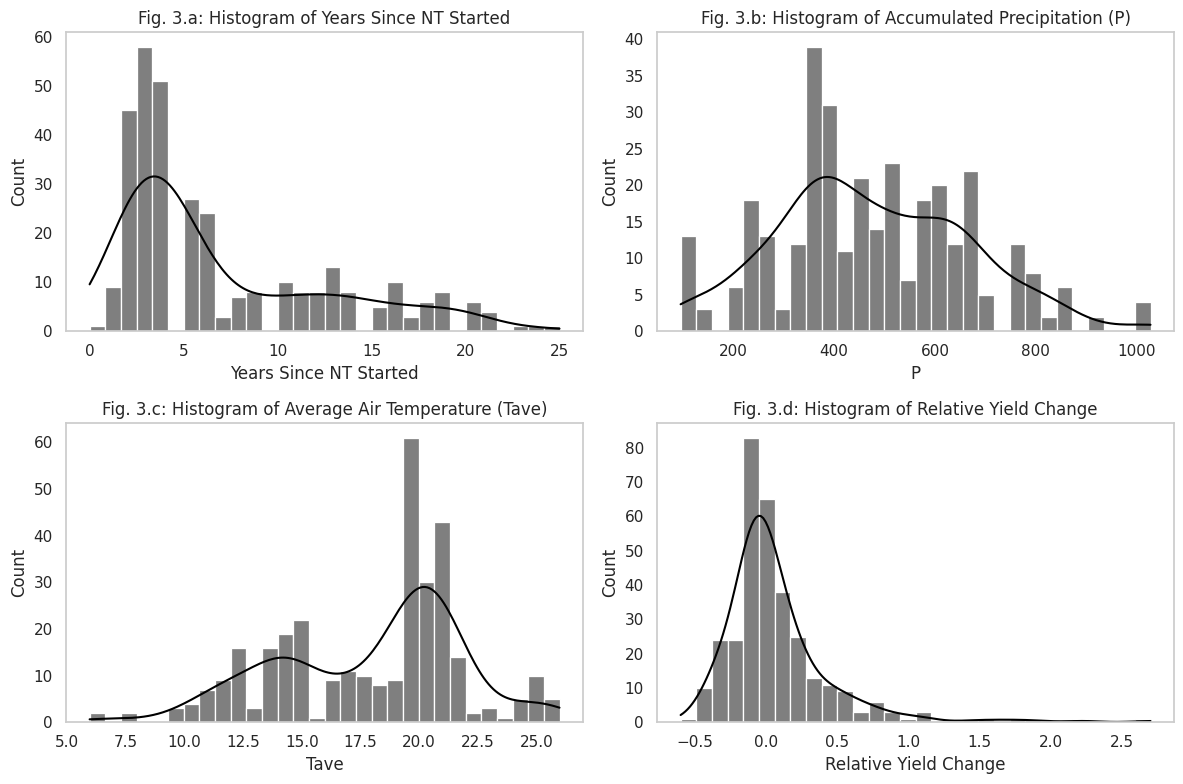

In [156]:
# Show distribution of the quantitative variables using subplots

# Set the style of seaborn
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))

# Create a histogram for 'years_since_nt_start' using seaborn
plt.subplot(2, 2, 1)
sns.histplot(df_NA_M_WW_clean_, x='years_since_nt_start', bins=30, color='black', kde=True)
plt.title('Fig. 3.a: Histogram of Years Since NT Started')
plt.xlabel('Years Since NT Started')
plt.ylabel('Count')
plt.grid(False)

# Create a histogram for 'p' using seaborn
plt.subplot(2, 2, 2)
sns.histplot(df_NA_M_WW_clean_, x='p', bins=30, color='black', kde=True)
plt.title('Fig. 3.b: Histogram of Accumulated Precipitation (P)')
plt.xlabel('P')
plt.ylabel('Count')
plt.grid(False)

# Create a histogram for 'tave' using seaborn
plt.subplot(2, 2, 3)
sns.histplot(df_NA_M_WW_clean_, x='tave', bins=30, color='black', kde=True)
plt.title('Fig. 3.c: Histogram of Average Air Temperature (Tave)')
plt.xlabel('Tave')
plt.ylabel('Count')
plt.grid(False)

# Create a histogram for 'relative_yield_change' (our response) using seaborn
plt.subplot(2, 2, 4)
sns.histplot(df_NA_M_WW_clean_, x='relative_yield_change', bins=30, color='black', kde=True)
plt.title('Fig. 3.d: Histogram of Relative Yield Change')
plt.xlabel('Relative Yield Change')
plt.ylabel('Count')
plt.grid(False)
plt.tight_layout()
plt.show()

All four quantitative variables of interest are visually skewed quite significantly, with the possible exception of "Accumulated Precipitation" (Figure 2.b). When building my model, I will check how transforming at least RYC reduces the skewness of the distributions.

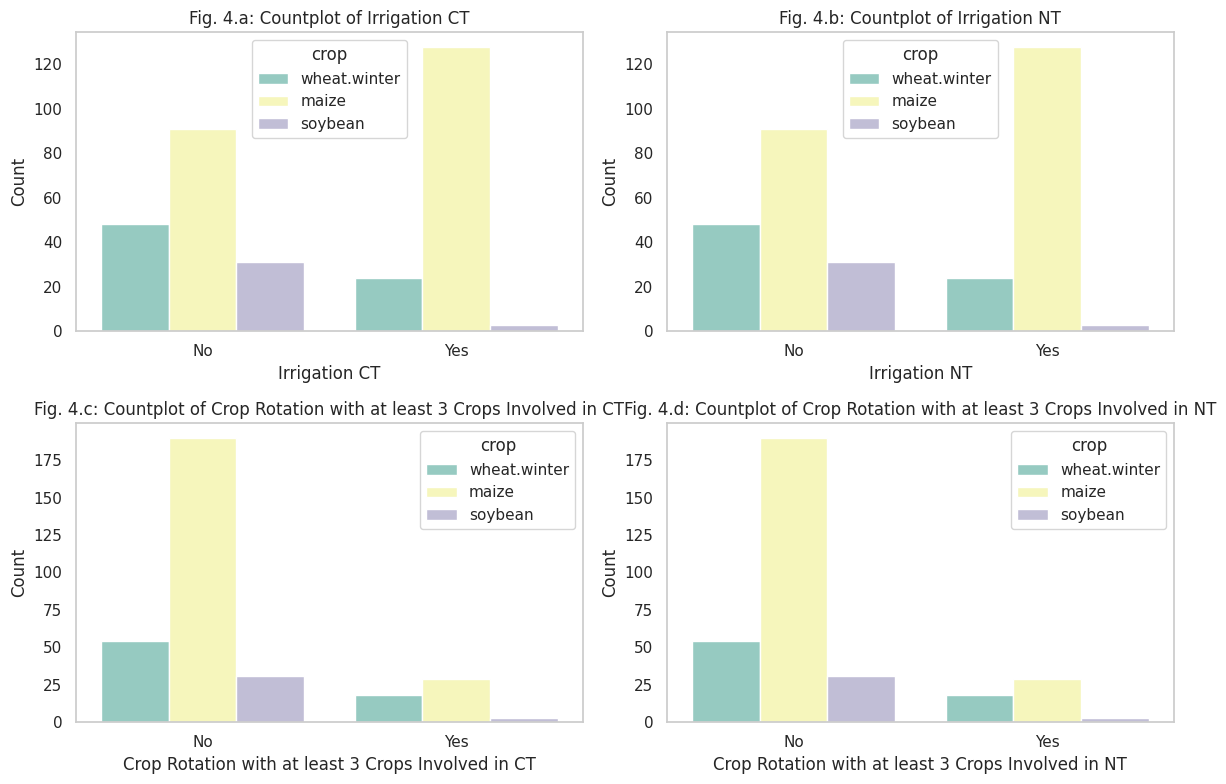

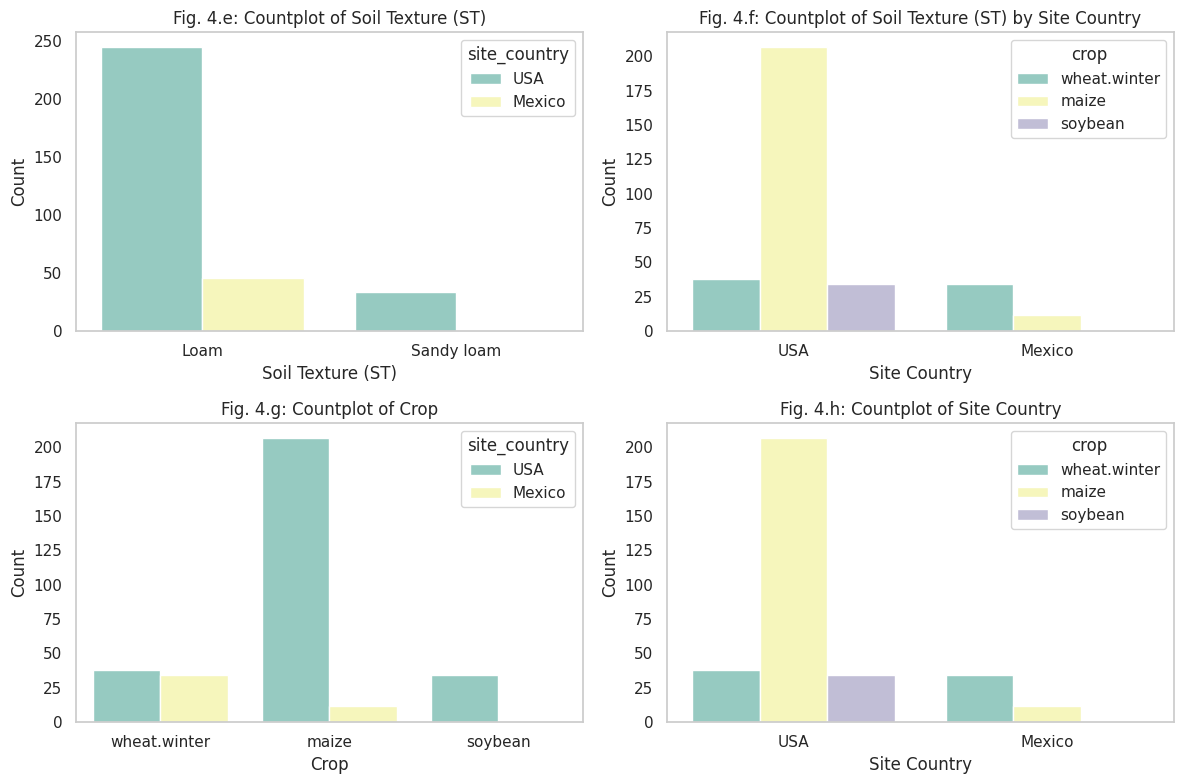

In [157]:
# Show the distribution of the qualitative variables using subplots
plt.figure(figsize=(12, 8))
# Create a countplot for 'irrigation_ct' using seaborn
plt.subplot(2, 2, 1)
sns.countplot(data=df_NA_M_WW_clean_, x='irrigation_ct', palette='Set3', hue='crop')
plt.title('Fig. 4.a: Countplot of Irrigation CT')
plt.xlabel('Irrigation CT')
plt.ylabel('Count')
plt.grid(False)
# Create a countplot for 'irrigation_nt' using seaborn
plt.subplot(2, 2, 2)
sns.countplot(data=df_NA_M_WW_clean_, x='irrigation_nt', palette='Set3', hue='crop')
plt.title('Fig. 4.b: Countplot of Irrigation NT')
plt.xlabel('Irrigation NT')
plt.ylabel('Count')
plt.grid(False)
# Create a countplot for 'crop_rotation_with_at_least_3_crops_involved_in_ct' using seaborn
plt.subplot(2, 2, 3)
sns.countplot(data=df_NA_M_WW_clean_, x='crop_rotation_with_at_least_3_crops_involved_in_ct', palette='Set3', hue='crop')
plt.title('Fig. 4.c: Countplot of Crop Rotation with at least 3 Crops Involved in CT')
plt.xlabel('Crop Rotation with at least 3 Crops Involved in CT')
plt.ylabel('Count')
plt.grid(False)
# Create a countplot for 'crop_rotation_with_at_least_3_crops_involved_in_nt' using seaborn
plt.subplot(2, 2, 4)
sns.countplot(data=df_NA_M_WW_clean_, x='crop_rotation_with_at_least_3_crops_involved_in_nt', palette='Set3', hue='crop')
plt.title('Fig. 4.d: Countplot of Crop Rotation with at least 3 Crops Involved in NT')
plt.xlabel('Crop Rotation with at least 3 Crops Involved in NT')
plt.ylabel('Count')
plt.grid(False)
plt.tight_layout()
plt.show()


# Create a countplot for 'st' using seaborn
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.countplot(data=df_NA_M_WW_clean_, x='st', palette='Set3', hue='site_country')
plt.title('Fig. 4.e: Countplot of Soil Texture (ST)')
plt.xlabel('Soil Texture (ST)')
plt.ylabel('Count')
plt.grid(False)

plt.subplot(2, 2, 2)
sns.countplot(data=df_NA_M_WW_clean_, x='site_country', palette='Set3', hue='crop')
plt.title('Fig. 4.f: Countplot of Soil Texture (ST) by Site Country')
plt.xlabel('Site Country')
plt.ylabel('Count')
plt.grid(False)


plt.subplot(2, 2, 3)
sns.countplot(data=df_NA_M_WW_clean_, x='crop', palette='Set3', hue='site_country')
plt.title('Fig. 4.g: Countplot of Crop')
plt.xlabel('Crop')
plt.ylabel('Count')
plt.grid(False)


plt.subplot(2, 2, 4)
sns.countplot(data=df_NA_M_WW_clean_, x='site_country', palette='Set3', hue='crop')
plt.title('Fig. 4.h: Countplot of Site Country')
plt.xlabel('Site Country')
plt.ylabel('Count')
plt.grid(False)
plt.tight_layout()
plt.show()


The most immediate issue is the underrepresentation of data from Mexico. I observed this earlier when assessing the sub-set of data from the USA and Mexico. The USA has 286 samples, while Mexico has only 51. This means the "SIte Country" variable is unbalanced, so I considered merging the two countries into one region, "USA-MEX," however the country may be important in the analysis, so I kept it as a variable in the analysis. The distribution of "Crop" is also unbalanced, with "maize" being greatly overepresented. And finally, Soil Type (ST) is greatly unbalanced, and the sampless in the lesser class, "Sandy Loam," appear only in the data from the USA. This unbalance in different variables will likely cause the model to poorly fit and produce skewed residuals.

The other very important clue I noticed in the pairs of plots for irrigation and crop rotation for each treatment, Figures 4.a and 4.b, and 4.c and 4.d. Within each pair, the counts for each treatment are identical, thus the treatments are collinear, allowing me to turn them into a single binary variable.

Next, I will check the correlation between the variables of interest and RYC. I will also check the correlation between the variables of interest and each other. I will use a heatmap to visualize this.

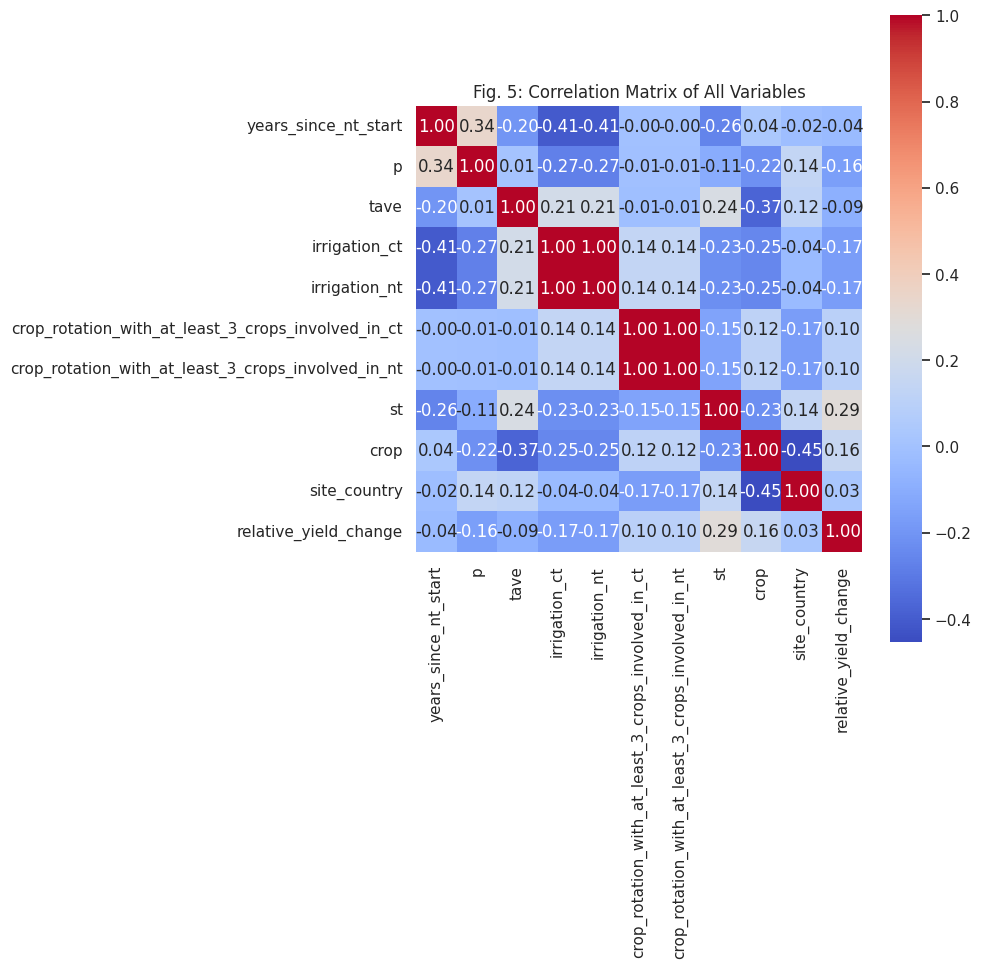

In [158]:
# Check correlation between all variables
correlation_matrix_df = df_NA_M_WW_clean_.drop(columns=['author', 'year', 'latitude', 'longitude'])
# Rye Python framework used for development does not access the correct library when adding the sklearn library (scikit-learn), so I will a different method

# Encode categorical variables
for col in correlation_matrix_df.select_dtypes(include=['object']).columns:
    correlation_matrix_df[col] = pd.Categorical(correlation_matrix_df[col]).codes

# Calculate the correlation matrix
correlation_matrix = correlation_matrix_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Fig. 5: Correlation Matrix of All Variables')
plt.tight_layout()
plt.show()

The correlation matrix in Figure 5 shows that the variables of interest are generally not highly correlated with each other, with the exception of Irrigation CT and Irrigation NT and Crop rotation CT* and Crop rotation NT*, which are both collinear with a correlation of 1, confirming what I suspected from the histogram analysis. There is a slight correlation between Irrigation (both CT and NT) and Years Since NT Started, between Crop and Site country, and between Crop and Average Temperature, however the values are all less than 0.5, so I will not be concerned about multicollinearity in the analysis.

The correlations between the variables of interest and the response variable, RYC, are not very strong, with the greatest correlation (in between the response and other variables of interest) being between RYC and Soil Type (ST), at 0.29. Not having strong correlations between the variables of interest and the response variable means that my model will not be able to explain a large amount of the variation in the response variable, which is a limitation of the analysis. However, I will still be able to assess the relative importance of the variables of interest in explaining the variation in the response variable.

There is also a slight correlation between Soil Type (ST) and Average Temperature (Tave), 0.24, so that may be an interesting interaction to explore in the analysis, though I must assess the Variance Inflation Factor (VIF) to determine if it is a problem for multicollinearity.

*Crop rotation CT = Crop rotation with at least 3 crops involved in CT, Crop rotation NT = Crop rotation with at least 3 crops involved in NT

In [159]:
df_NA_M_WW_clean_.to_csv('NA_M_WW_clean.csv', index=False)

## 04 | Statistical Analysis
<a id="04"></a>

### 04.1 | Data Transformation

In [160]:
df_analysis = pd.read_csv('NA_M_WW_clean.csv')
print("DataFrame 'df_analysis' loaded successfully.")
print(f"Original shape: {df_analysis.shape}")

print("\nSkewness Before Transformation:")
print(f"years_since_nt_start: {df_analysis['years_since_nt_start'].skew():.2f}")
print(f"p: {df_analysis['p'].skew():.2f}")
print(f"tave: {df_analysis['tave'].skew():.2f}")
print(f"relative_yield_change (our response): {df_analysis['relative_yield_change'].skew():.2f}")

# 1. years_since_nt_start (Right Skewed)
df_analysis['years_log1p'] = np.log1p(df_analysis['years_since_nt_start'])

# 2. p (Accumulated Precipitation, Right Skewed)
if (df_analysis['p'] > 0).all():
    df_analysis['p_log'] = np.log(df_analysis['p'])
else:
    print("Warning: Column 'p' contains non-positive values. Using log1p instead of log.")
    df_analysis['p_log'] = np.log1p(df_analysis['p'])

# 3. tave (Average Air Temperature, Left Skewed)
max_tave = df_analysis['tave'].max()
df_analysis['tave_reflected'] = max_tave + 1 - df_analysis['tave']
df_analysis['tave_reflected_log1p'] = np.log1p(df_analysis['tave_reflected'])

# 4. relative_yield_change (Response)
# Transform the response variable using log1p since it can be negative
df_analysis['logp_ryc'] = np.log1p(df_analysis['relative_yield_change'])

print("\nSkewness After Transformation:")
print(f"years_log1p: {df_analysis['years_log1p'].skew():.2f}")
print(f"p_log: {df_analysis['p_log'].skew():.2f}")
print(f"tave_reflected_log1p: {df_analysis['tave_reflected_log1p'].skew():.2f}")
print(f"logp_ryc (our response): {df_analysis['logp_ryc'].skew():.2f}")

DataFrame 'df_analysis' loaded successfully.
Original shape: (325, 15)

Skewness Before Transformation:
years_since_nt_start: 1.15
p: 0.30
tave: -0.44
relative_yield_change (our response): 2.76

Skewness After Transformation:
years_log1p: 0.32
p_log: -1.01
tave_reflected_log1p: -0.86
logp_ryc (our response): 0.90


In [161]:
# Check if NaNs were introduced
print(f"Number of NaNs in new response: {df_analysis['logp_ryc'].isnull().sum()}")
print(f"Min value of relative_yield_change: {df_analysis['relative_yield_change'].min()}")

Number of NaNs in new response: 0
Min value of relative_yield_change: -0.5972


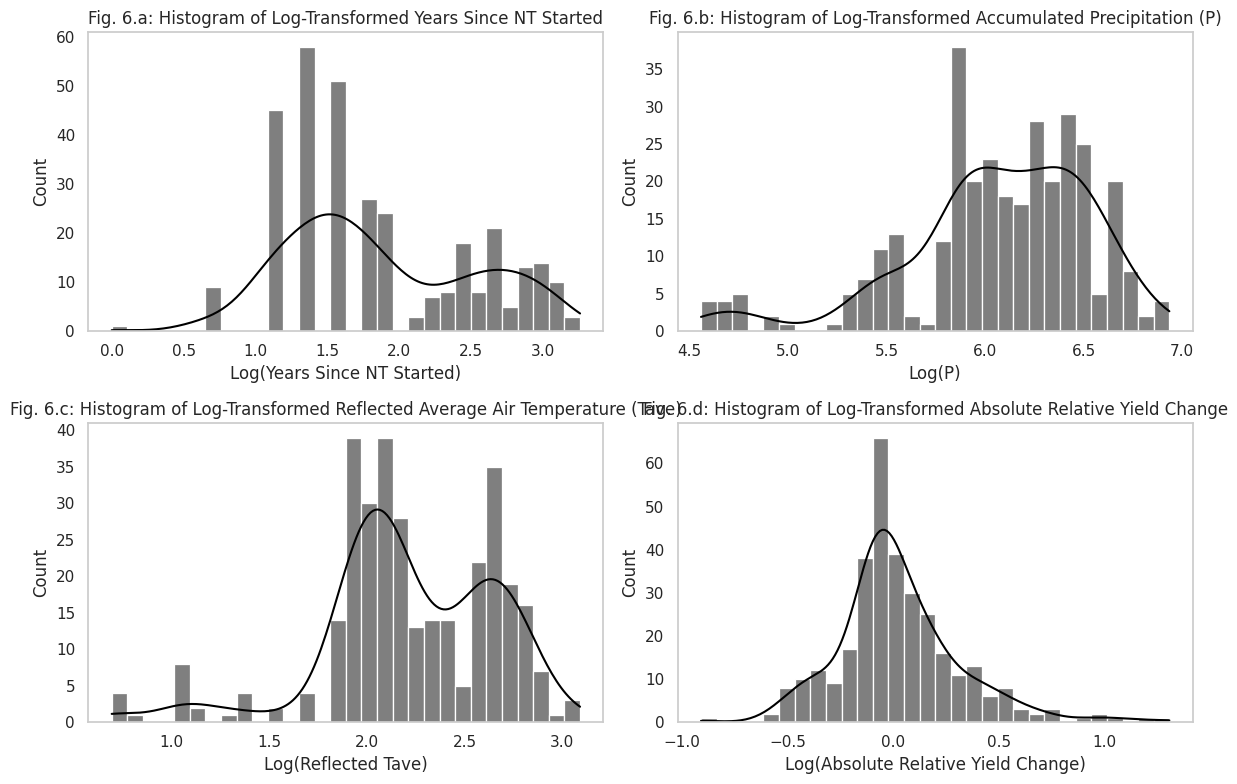

In [162]:
# Check the distribution of the transformed variables

plt.figure(figsize=(12, 8))
# Create a histogram for 'years_log1p' using seaborn
plt.subplot(2, 2, 1)
sns.histplot(df_analysis, x='years_log1p', bins=30, color='black', kde=True)
plt.title('Fig. 6.a: Histogram of Log-Transformed Years Since NT Started')
plt.xlabel('Log(Years Since NT Started)')
plt.ylabel('Count')
plt.grid(False)

# Create a histogram for 'p_log' using seaborn
plt.subplot(2, 2, 2)
sns.histplot(df_analysis, x='p_log', bins=30, color='black', kde=True)
plt.title('Fig. 6.b: Histogram of Log-Transformed Accumulated Precipitation (P)')
plt.xlabel('Log(P)')
plt.ylabel('Count')
plt.grid(False)

# Create a histogram for 'tave_reflected_log1p' using seaborn
plt.subplot(2, 2, 3)
sns.histplot(df_analysis, x='tave_reflected_log1p', bins=30, color='black', kde=True)
plt.title('Fig. 6.c: Histogram of Log-Transformed Reflected Average Air Temperature (Tave)')
plt.xlabel('Log(Reflected Tave)')
plt.ylabel('Count')
plt.grid(False)

# Create a histogram for 'log_abs_ryc' using seaborn
plt.subplot(2, 2, 4)
sns.histplot(df_analysis, x='logp_ryc', bins=30, color='black', kde=True)
plt.title('Fig. 6.d: Histogram of Log-Transformed Absolute Relative Yield Change')
plt.xlabel('Log(Absolute Relative Yield Change)')
plt.ylabel('Count')
plt.grid(False)
plt.tight_layout()
plt.show()

The transformations helped to reduce the skewness of "Years Since NT Started" and RYC, but overcorrected the skewness of "Average Temperature" and "Accumulated Precipitation." I will not use the transformed versions of these variables in the analysis, but I will use the transformed versions of "Years Since NT Started" and RYC.

In [163]:
# Drop 'log_p', 'tave_reflected_log1p', 'tave_reflected', 'years_since_nt_start', 'abs_ryc' from the DataFrame (they are not needed anymore)
df_analysis.drop(columns=['p_log', 'tave_reflected_log1p', 'tave_reflected', 'relative_yield_change', 'years_since_nt_start'], inplace=True)
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325 entries, 0 to 324
Data columns (total 15 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   author                                              325 non-null    object 
 1   year                                                325 non-null    object 
 2   latitude                                            325 non-null    float64
 3   longitude                                           325 non-null    float64
 4   p                                                   325 non-null    float64
 5   tave                                                325 non-null    float64
 6   irrigation_ct                                       325 non-null    object 
 7   irrigation_nt                                       325 non-null    object 
 8   crop_rotation_with_at_least_3_crops_involved_in_ct  325 non-null    object 
 9  

### 04.2 | Model Selection for Additive Analysis


--- Predictor Preparation ---
Irrigation CT and NT are always the same. Creating a single 'irrigation' variable.
Crop rotation CT and NT are always the same. Creating a single 'crop_rotation' variable.

Regression model formula:
logp_ryc ~ C(st) + C(irrigation) + C(crop_rotation) + C(crop) + C(site_country) + years_log1p + p + tave

--- Regression Model Summary ---
                            OLS Regression Results                            
Dep. Variable:               logp_ryc   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     9.738
Date:                Sun, 11 May 2025   Prob (F-statistic):           3.74e-13
Time:                        06:53:24   Log-Likelihood:                -22.395
No. Observations:                 325   AIC:                             64.79
Df Residuals:                     315   BIC:                             102.6

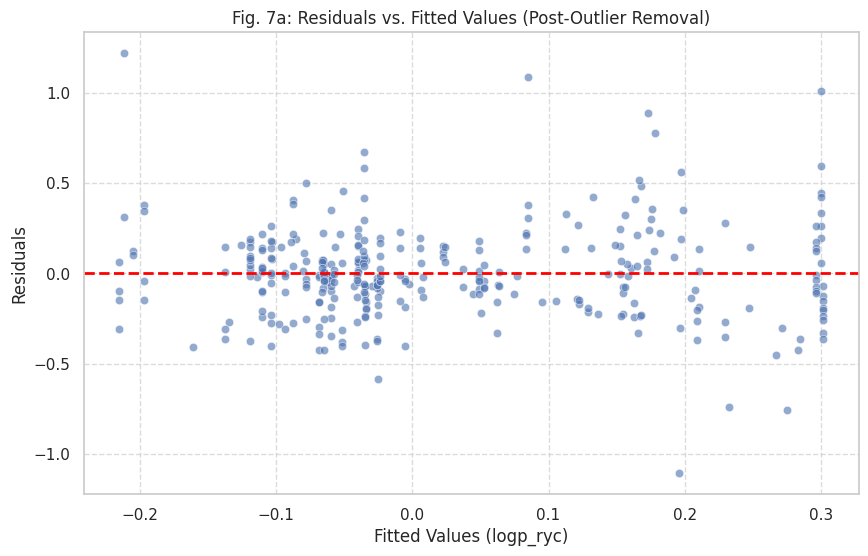

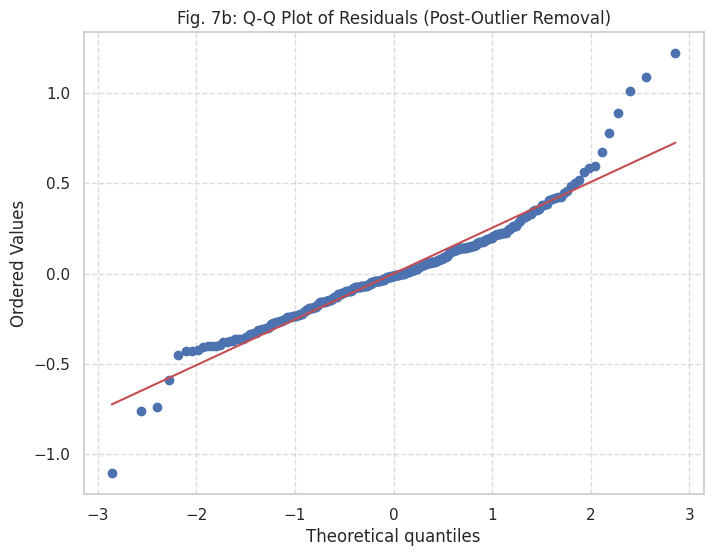

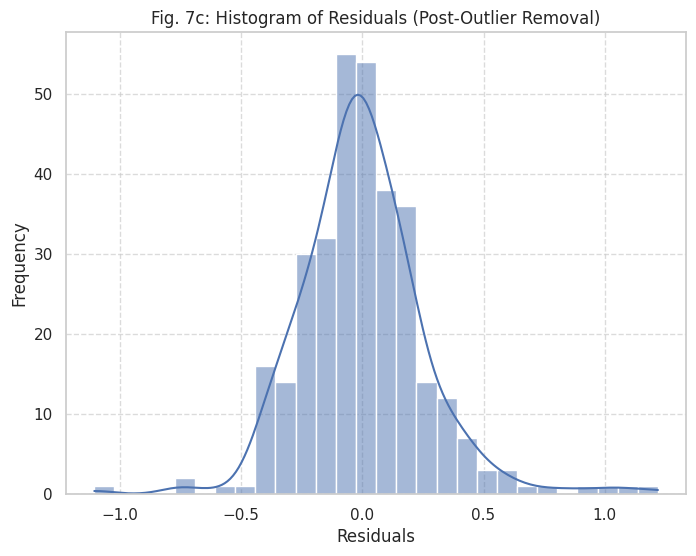


Shapiro-Wilk test for normality of residuals: W=0.9465, p-value=0.0000
Residuals are not normally distributed (reject H0).

Breusch-Pagan test for homoscedasticity: p-value=0.0101
Heteroscedasticity detected (reject H0).

Residual skewness or kurtosis is high, or heteroscedasticity detected. Consider robust regression.

--- Robust Regression Model (RLM) Summary ---
                    Robust linear Model Regression Results                    
Dep. Variable:               logp_ryc   No. Observations:                  325
Model:                            RLM   Df Residuals:                      315
Method:                          IRLS   Df Model:                            9
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 11 May 2025                                         

In [164]:
df_model = df_analysis.copy()

# --- 1. Prepare Qualitative Predictors ---
print("\n--- Predictor Preparation ---")
if (df_model['irrigation_ct'] == df_model['irrigation_nt']).all():
    print("Irrigation CT and NT are always the same. Creating a single 'irrigation' variable.")
    df_model['irrigation'] = df_model['irrigation_nt']
else:
    print("Warning: Irrigation CT and NT differ. Using 'irrigation_nt'.")
    df_model['irrigation'] = df_model['irrigation_nt']

if (df_model['crop_rotation_with_at_least_3_crops_involved_in_ct'] == df_model['crop_rotation_with_at_least_3_crops_involved_in_nt']).all():
    print("Crop rotation CT and NT are always the same. Creating a single 'crop_rotation' variable.")
    df_model['crop_rotation'] = df_model['crop_rotation_with_at_least_3_crops_involved_in_nt']
else:
    print("Warning: Crop rotation CT and NT differ. Using 'crop_rotation_..._nt'.")
    df_model['crop_rotation'] = df_model['crop_rotation_with_at_least_3_crops_involved_in_nt']

# --- 3. Build and Fit the OLS Model (Post-Outlier Removal) ---
formula = 'logp_ryc ~ C(st) + C(irrigation) + C(crop_rotation) + C(crop) + C(site_country) + years_log1p + p + tave'
print(f"\nRegression model formula:\n{formula}")

try:
    ols_model = smf.ols(formula, data=df_model).fit()
    print("\n--- Regression Model Summary ---")
    print(ols_model.summary())

    # --- 4. Investigate Multicollinearity (VIFs) ---
    print("\n--- Variance Inflation Factor (VIF) Analysis ---")
    # Create the design matrix using patsy's dmatrices
    y, X = dmatrices(formula, data=df_model, return_type='dataframe')
    X = sm.add_constant(X)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\n--- VIF Analysis ---")
    print("VIF values for predictors:")
    print(vif_data[vif_data["feature"] != "Intercept"])

    # --- 5. Thorough Residual Analysis (Post-Outlier Removal) ---
    print("\n--- Residual Analysis (Post-Outlier Removal) ---")
    residuals = ols_model.resid
    fitted_values = ols_model.fittedvalues

    print(f"Skewness of new residuals: {residuals.skew():.2f}")
    print(f"Kurtosis of new residuals (Fisher): {residuals.kurtosis():.2f}")

    # 5a. Residuals vs. Fitted Values Plot (Homoscedasticity)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=fitted_values, y=residuals, alpha=0.6)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)
    plt.title('Fig. 7a: Residuals vs. Fitted Values (Post-Outlier Removal)')
    plt.xlabel('Fitted Values (logp_ryc)')
    plt.ylabel('Residuals')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # 5b. Q-Q Plot of Residuals (Normality)
    plt.figure(figsize=(8, 6))
    stats.probplot(residuals, dist="norm", plot=plt)
    plt.title('Fig. 7b: Q-Q Plot of Residuals (Post-Outlier Removal)')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

    # 5c. Histogram of Residuals
    plt.figure(figsize=(8, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Fig. 7c: Histogram of Residuals (Post-Outlier Removal)')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()


    # Shapiro-Wilk test for normality
    shapiro_test = stats.shapiro(residuals)
    print(f"\nShapiro-Wilk test for normality of residuals: W={shapiro_test.statistic:.4f}, p-value={shapiro_test.pvalue:.4f}")
    if shapiro_test.pvalue < 0.05:
        print("Residuals are not normally distributed (reject H0).")
    else:
        print("Residuals are normally distributed (fail to reject H0).")

    # Breusch-Pagan test for homoscedasticity
    _, BP_pval, _, _ = sm.stats.diagnostic.het_breuschpagan(residuals, ols_model.model.exog)
    print(f"\nBreusch-Pagan test for homoscedasticity: p-value={BP_pval:.4f}")
    if BP_pval < 0.05:
        print("Heteroscedasticity detected (reject H0).")
    else:
        print("No heteroscedasticity detected (fail to reject H0).")

    # --- 6. Consideration for Robust Regression ---
    if abs(residuals.skew()) > 2 or abs(residuals.kurtosis()) > 3 or BP_pval < 0.05:
        print("\nResidual skewness or kurtosis is high, or heteroscedasticity detected. Consider robust regression.")
        try:
            rlm_model = smf.rlm(formula, data=df_model, M=sm.robust.norms.HuberT()).fit()
            print("\n--- Robust Regression Model (RLM) Summary ---")
            print(rlm_model.summary())
        except Exception as e_rlm:
            print(f"Error fitting RLM model: {e_rlm}")
    else:
        print("\nResidual diagnostics have improved significantly. OLS model may be adequate.")


except Exception as e:
    print(f"\nError during model fitting or analysis: {e}")
    print("Please check data integrity and variable names.")

The kurtosis of the residuals calculated by the OLS model is 3.75, so even though the residuals look mostly normal, there is still a significant positive tail that I find suspicious (365 Data Science, n.d.). In addition, a Shapiro-Wilk test of the residuals indicates non-normality and a Breusch-Pagan test indicates heteroscedasticity at the 0.05 level of significance. Therefore, I will proceed with the Robust Linear Model.

Based on the significance of Soil Type (ST) and Average Temperature (Tave) in the analysis and the principle of heredity, I will also test the interaction between these two variables.

### 04.3 | Interaction Model

In [165]:
colorMap = {'Loam': 'blue', 'Sandy loam': 'orange'}
# Interaction plot between tave and st
fig = px.scatter(df_model, x='tave', y='logp_ryc', color='st', symbol='site_country', title='Fig. 8: Interaction plot of Average Temp vs. Log(RYC + 1) by Soil Type (ST)')
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='black')), selector=dict(mode='markers'))
fig.update_layout(
    xaxis_title='Average Air Temperature (Tave)',
    yaxis_title='Log(Absolute Relative Yield Change)',
    legend_title_text='Soil Texture (ST)',
    showlegend=True,
)
# Add lines of best fit for each soil type
for soil_type in df_model['st'].unique():
    soil_data = df_model[df_model['st'] == soil_type]
    slope, intercept = np.polyfit(soil_data['tave'], soil_data['logp_ryc'], 1)
    x_line = np.linspace(soil_data['tave'].min(), soil_data['tave'].max(), 100)
    y_line = slope * x_line + intercept
    fig.add_trace(go.Scatter(x=x_line, y=y_line, mode='lines', name=f'{soil_type} Line of Best Fit', line=dict(color=colorMap[soil_type])))

fig.show()

Figure 8 shows a slight narrowing, or reduction in variance in RYC at higher tempetures for the "Loam" soil type or class and has a large temperature range (\~6-22), while most of the "Sandy loam" samples are clustered around 19.4, 21, and 21.2 degrees, and only have a range of about 8 (\~17-25). The temperature ranges themselves are likely due to more trials being done in a certain region within each country than another, and I could have likely used the longitude and latitude, or an intra-region calculated from the former to block location-based variance.

However, what is more interesting are the lines of best fit for each soil type in Figure 8: The center of RYC moves lower as temperatures rise for plantings in "Loam soil whereas the center of RYC moves higher as temperatures rise, possibly indicating an interception at \~14.5 degrees (if there were data to show that) and suggesting temperature may affect how different soil types become or remain conducive to high-yield growing conditions.

In [166]:
# --- Interaction Model 1: Soil Texture * Average Temperature ---

formula_interaction_st_tave = 'logp_ryc ~ C(st) * tave + C(irrigation) + C(crop_rotation) + C(crop) + C(site_country) + years_log1p + p'

print(f"\nInteraction Model Formula (st * tave):\n{formula_interaction_st_tave}")

try:
    rlm_interaction_model = smf.rlm(formula_interaction_st_tave, data=df_model, M=sm.robust.norms.HuberT()).fit()
    print("\n--- RLM Interaction Model (st * tave) Summary ---")
    print(rlm_interaction_model.summary())

    print("\n--- VIF Analysis for RLM Interaction Model (st * tave) ---")
    y_int, X_int = dmatrices(formula_interaction_st_tave, data=df_model, return_type='dataframe')

    vif_data_int = pd.DataFrame()
    vif_data_int["feature"] = X_int.columns
    # Calculate VIF, handling potential perfect collinearity if a term is problematic
    vifs = []
    for i in range(X_int.shape[1]):
        try:
            vif = variance_inflation_factor(X_int.values, i)
        except Exception as e:
            print(f"Could not calculate VIF for {X_int.columns[i]}: {e}")
            vif = np.nan
        vifs.append(vif)
    vif_data_int["VIF"] = vifs

    print("VIF values for predictors (including interaction terms):")
    print(vif_data_int[vif_data_int["feature"] != "Intercept"])

except Exception as e:
    print(f"\nError during interaction model fitting or analysis: {e}")


Interaction Model Formula (st * tave):
logp_ryc ~ C(st) * tave + C(irrigation) + C(crop_rotation) + C(crop) + C(site_country) + years_log1p + p

--- RLM Interaction Model (st * tave) Summary ---
                    Robust linear Model Regression Results                    
Dep. Variable:               logp_ryc   No. Observations:                  325
Model:                            RLM   Df Residuals:                      314
Method:                          IRLS   Df Model:                           10
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 11 May 2025                                         
Time:                        06:53:25                                         
No. Iterations:                    24                                         
              

The interaction between Soil Type (ST) and Average Temperature (Tave) is significant, but the VIF is very high (115.21), so I will center "Average Temperature (Tave)" to reduce the multicollinearity, and then re-test the interaction.

In [167]:
df_model['tave_centered'] = df_model['tave'] - df_model['tave'].mean()

# New formula with centered tave
formula_interaction_st_tave_centered = 'logp_ryc ~ C(st) * tave_centered + C(irrigation) + C(crop_rotation) + C(crop) + C(site_country) + years_log1p + p'

# Fit RLM with this new formula
rlm_interaction_model_centered = smf.rlm(formula_interaction_st_tave_centered, data=df_model, M=sm.robust.norms.HuberT()).fit()
print("\n--- RLM Interaction Model (st * tave, centered) Summary ---")
print(rlm_interaction_model_centered.summary())

# Recalculate VIFs with tave_centered
y_int_c, X_int_c = dmatrices(formula_interaction_st_tave_centered, data=df_model, return_type='dataframe')
vif_data_int_c = pd.DataFrame()
vif_data_int_c["feature"] = X_int_c.columns
vifs_c = []

for i in range(X_int_c.shape[1]):
    try:
        vif = variance_inflation_factor(X_int_c.values, i)
    except Exception as e:
        print(f"Could not calculate VIF for {X_int_c.columns[i]}: {e}")
        vif = np.nan
    vifs_c.append(vif)
vif_data_int_c["VIF"] = vifs_c
print("VIF values for predictors (including interaction terms with centered tave):")
print(vif_data_int_c[vif_data_int_c["feature"] != "Intercept"])


--- RLM Interaction Model (st * tave, centered) Summary ---
                    Robust linear Model Regression Results                    
Dep. Variable:               logp_ryc   No. Observations:                  325
Model:                            RLM   Df Residuals:                      314
Method:                          IRLS   Df Model:                           10
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 11 May 2025                                         
Time:                        06:53:25                                         
No. Iterations:                    24                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

## 05 | Discussion
<a id="05"></a>

### 05.1 | Interpretation of Significant Findings from the Robust Interaction Model

In my investigation of factors influencing the relative yield change between no-tillage (NT) and conventional tillage (CT) systems, I ultimately focused on a Robust Linear Model (RLM) due to observed non-normality and heteroscedasticity in the residuals of an initial Ordinary Least Squares (OLS) model. This RLM provided some intriguing insights into the performance of NT for maize, winter wheat, and soybean crops in the U.S. and Mexico.

The most notable result I found was the **statistically significant interaction (p = 0.002) between soil texture (`st`) and centered average temperature (`tave_centered`)**. This suggests that the way temperature influences the relative performance of NT is not uniform but rather depends on the soil's textural class.
Specifically:
*   For **Loam soils** (which served as my reference category), the effect of `tave_centered` on `logp_ryc` was very small and not statistically significant (slope for Loam ≈ +0.0002, p = 0.961). This implies that, on Loam soils in this dataset, changes in average temperature (around the mean) did not have a clear, discernible impact on whether NT performed better or worse than CT.
*   However, for **Sandy Loam soils**, the effect of `tave_centered` was significantly positive. I calculated this slope as the sum of the `tave_centered` coefficient and the interaction term's coefficient (`0.0002 + 0.0636 = +0.0638`). This positive relationship indicates that on Sandy Loam soils, as average temperatures increased (relative to the mean), the performance of NT relative to CT tended to improve. I hypothesize this could be linked to the better water conservation often attributed to NT systems, which might become particularly advantageous on coarser-textured sandy loams that have inherently lower water-holding capacity (Ibrahimi & Alghamdi, 2022), especially under warmer conditions that increase evaporative demand.

Beyond this key interaction, I identified several other predictors with significant main effects in the final RLM interaction model:

*   **Crop Rotation (`C(crop_rotation)[T.Yes]`):** My analysis showed that implementing a complex crop rotation (involving at least three crops) was associated with a significant improvement in the relative performance of NT (coef = 0.145, p < 0.000). This aligns well with established conservation agriculture principles, where diverse rotations are thought to enhance soil health and synergize with NT benefits.
*   **Crop Type:**
    *   **Wheat (Winter) (`C(crop)[T.wheat.winter]`):** Compared to maize (my reference crop), winter wheat showed significantly better relative performance under NT (coef = 0.215, p < 0.000).
    *   **Soybean (`C(crop)[T.soybean]`):** I found no significant difference in relative NT performance between soybean and maize (p = 0.841).
*   **Site Country (`C(site_country)[T.USA]`):** My results indicated that experiments conducted in the USA showed significantly better relative NT performance compared to those in Mexico (my reference country) (coef = 0.165, p < 0.000), after accounting for other factors.
*   **Precipitation (`p`):** I observed that higher accumulated precipitation during the growing season was significantly associated with a decrease in the relative performance of NT (coef = -0.0002, p = 0.003). This might suggest that under wetter conditions in these regions and for these crops, NT systems could face challenges (e.g., drainage, compaction) that are mitigated more effectively by conventional tillage.

### 05.2 | Discussion of Non-Significant Factors

In my final robust interaction model, several factors did not emerge as statistically significant predictors of the `log1p`-transformed relative yield change. The log-transformed number of years since NT was initiated (`years_log1p`) showed no clear effect. Similarly, after accounting for the interaction and other significant factors, the main effect of irrigation (`C(irrigation)[T.Yes]`) also lost its earlier borderline significance (p = 0.170 in the final RLM interaction model). This suggests that while irrigation might have appeared influential in simpler models, its effect on relative NT performance was not robust once more complex relationships, like the soil-temperature interaction and country/crop differences, were considered.

### 05.3 Methodological Considerations

I initially focused on the relative yield change (`RYC`) as my response. Recognizing its non-normal distribution (skew of 2.76 after initial outlier removal), I applied a `log1p` transformation (`log(1 + x)`), which was appropriate given that all `RYC` values in my cleaned dataset were greater than -1. This transformation resulted in a `logp_ryc` variable with a more manageable skew of 0.90.

I first fitted an Ordinary Least Squares (OLS) additive model. Although the VIF values from this OLS model were all low (max ~2.1), indicating no problematic multicollinearity among the additive predictors, the residual diagnostics were a concern. The Shapiro-Wilk test (p < 0.0001) strongly rejected the normality of residuals, and the Breusch-Pagan test (p = 0.0101) indicated heteroscedasticity. These violations prompted my decision to use Robust Linear Models (RLM) with Huber's T norm for subsequent analyses. RLM provides more trustworthy estimates when OLS assumptions about the error distribution are not met.

Following the principle of heredity, I then explored an interaction between soil texture (`st`) and average temperature (`tave`), as both had shown some influence in earlier model iterations or were theoretically compelling. To address the high VIFs that arose between the `st` main effect and the `st:tave` interaction term in the initial interaction model, I centered the `tave` variable (`tave_centered = tave - mean(tave)`). This successfully reduced all VIFs in the final RLM interaction model to acceptable levels (max ~4.15), ensuring the stability and interpretability of the model coefficients.

### 05.4 | Limitations

I acknowledge several limitations in this study. First, the OLS R-squared value for the additive model was approximately 0.218, indicating that while my model identified several significant factors, a substantial portion of the variability in relative NT performance remains unexplained. This is common in analyses of complex agricultural systems using meta-analysis data, where many site-specific nuances (e.g., specific management details within NT, soil fertility beyond texture, pest pressures) are not captured.

Second, my findings are specific to the crops I analyzed (maize, winter wheat, soybean) and the geographic scope (U.S. and Mexico). Generalizing these results to other agricultural contexts should be done with caution. The "Site Country" variable, while significant, likely acts as a proxy for a host of unmeasured differences in climate, common farming practices, and economic conditions between the U.S. and Mexico.

Third, the categorical variables I used, such as soil texture ('Loam' vs. 'Sandy Loam'), necessarily simplify a more continuous reality and group potentially diverse conditions.

Finally, while RLM addresses issues with non-normal residuals, the interpretation of effect sizes is based on the transformed response variable (`logp_ryc`), which is less direct than interpreting effects on raw RYC.

### 05.5 | Implications and Future Research

Despite these limitations, my findings have potentially useful implications. The strong soil texture-temperature interaction I identified suggests that adaptive management strategies for tillage could be beneficial. For instance, in regions with predominantly Sandy Loam soils, NT might become increasingly advantageous relative to CT as temperatures rise, while this may not be the case on Loam soils. The consistent positive impact of complex crop rotations on NT's relative performance reinforces existing recommendations for diversified cropping systems within conservation agriculture. The negative associations I found with irrigation and higher precipitation warrant further investigation to understand if they represent fundamental limitations of NT under those conditions or opportunities for refining NT practices (e.g., improved drainage solutions in NT for high rainfall areas).

Future research could unpack the "Site Country" effect by incorporating more granular regional or climatic zone data. Exploring additional soil properties beyond basic texture, if available in expanded datasets, could further refine our understanding of the soil-climate interactions. Given the variability, continuing to build larger, more detailed datasets that include nuanced management information will be key to developing increasingly precise, context-specific guidance for tillage system selection.

## 06 | Conclusion
<a id="06"></a>

In my analysis of the Su et al. (2021) dataset, focusing on maize, winter wheat, and soybean production in the U.S. and Mexico, I sought to understand the factors influencing the relative yield performance of no-tillage (NT) compared to conventional tillage (CT). By employing robust linear modeling on the `log1p`-transformed relative yield change, I was able to account for complexities in the data distribution and identify several key influences.

I found that management practices such as implementing a complex crop rotation significantly enhanced the relative performance of NT. Conversely, higher precipitation levels were associated with a decrease in NT's relative advantage. Crop type also played a role, with winter wheat showing better relative NT performance compared to maize. Furthermore, experiments in the USA, on average, reported better relative NT outcomes than those in Mexico, after accounting for other modeled factors.

Perhaps my most important finding was a significant interaction between soil texture and average temperature. This interaction revealed that on Sandy Loam soils, warmer temperatures tended to improve NT's relative performance, whereas on Loam soils, temperature did not have a clear, significant effect. This highlights that the impact of climate variables on tillage system performance can be highly dependent on soil context. While factors such as the duration of NT adoption and irrigation did not show robust, significant effects in my final interaction model, the factors I did identify underscore the multifaceted nature of NT performance. My results contribute to a more granular understanding that can help inform decisions about tillage practices in the specific agricultural contexts I studied.

## References
<a id="references"></a>

Ibrahimi, K., & Alghamdi, A. G. (2022). Available water capacity of sandy soils as affected by biochar application: A meta-analysis. CATENA, 214, 106281. doi:10.1016/j.catena.2022.106281

Lal, R. (2004) Soil Carbon Sequestration Impacts on Global Climate Change and Food Security. Science, 304, 1623-1627.
https://doi.org/10.1126/science.1097396

Pittelkow, C., Liang, X., Linquist, B. et al. Productivity limits and potentials of the principles of conservation agriculture. Nature 517, 365–368 (2015). https://doi.org/10.1038/nature13809

Su, Y., Gabrielle, B. & Makowski, D. A global dataset for crop production under conventional tillage and no tillage systems. Sci Data 8, 33 (2021). https://doi.org/10.1038/s41597-021-00817-x

365 Data Science. (n.d.-a). Kurtosis calculator. 365 Data Science. https://365datascience.com/calculators/kurtosis-calculator/